In [ ]:
import warnings
import numpy as np

warnings.simplefilter("ignore", category=np.exceptions.VisibleDeprecationWarning)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from graph_cut import * 


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from sklearn.cluster import KMeans
import maxflow
from graph_cut import * 


(576, 720, 3)
labels (576, 720)


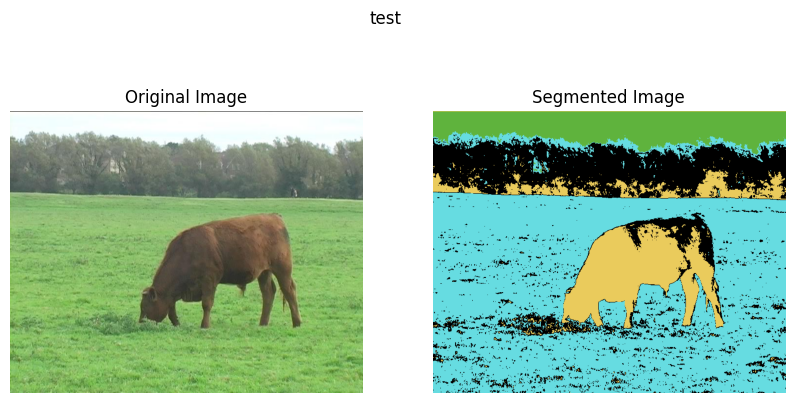

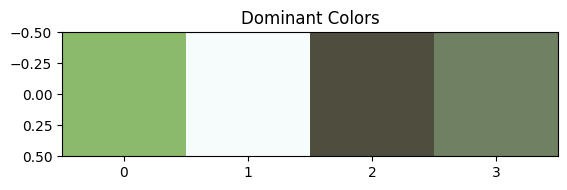

In [4]:
image_path = "images/cow.ppm"  # Replace with actual image path
K=4
image = load_image(image_path)
print(image.shape)
labels = initialize_labels_bis(image, K=K, method='kmeans')
print("labels", labels.shape)
show_segmentation(image, labels,title="test")
show_dominant_colors(labels=labels,image=image,K=K)

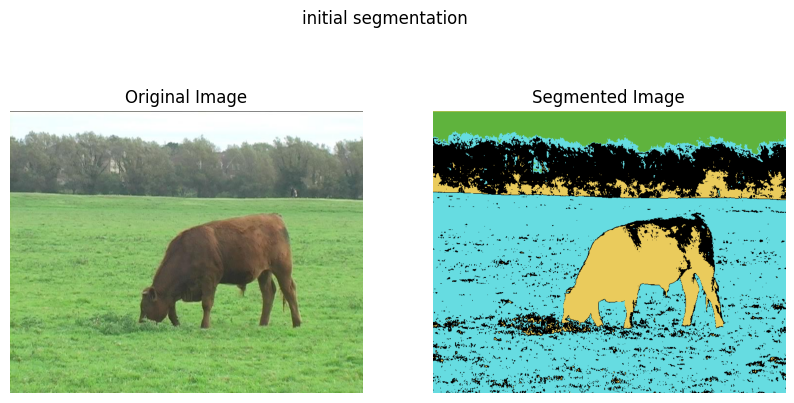

In [60]:
image_path = "images/cow.ppm"  # Replace with actual image path
K=4
image = load_image(image_path)
labels = initialize_labels_bis(image, K=K, method='kmeans')
show_segmentation(image, labels,title="initial segmentation")

histograms = compute_histograms(image, labels, K=K, bins = 16)
unary_term=compute_unary_term(image,labels,histograms,K,16)
# dominants_colors=get_dominant_colors(labels=labels, image=image, K=K)
# unary_term = compute_unary_term_L2(image,dominants_colors)
pairwise_term = compute_pairwise_term(image, K=K, lambda_val=200)


In [6]:
unary_term[60,50,:]

array([ 53.87833954, 201.44101178, 105.01244316,  38.94024483])

In [7]:
pairwise_term[0,0]

array([[  0., 200., 200., 200.],
       [200.,   0., 200., 200.],
       [200., 200.,   0., 200.],
       [200., 200., 200.,   0.]])

(576, 720)


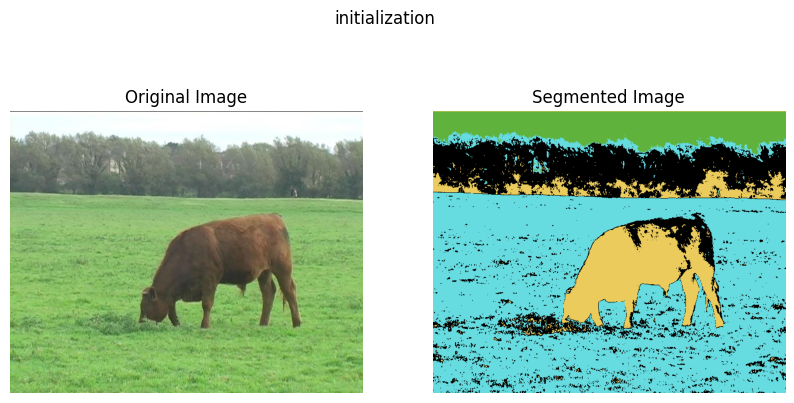

first energy 19243970.73962337
iterations nb: 0
computed energy 12809621.851808785 is it greater than initial energy? False


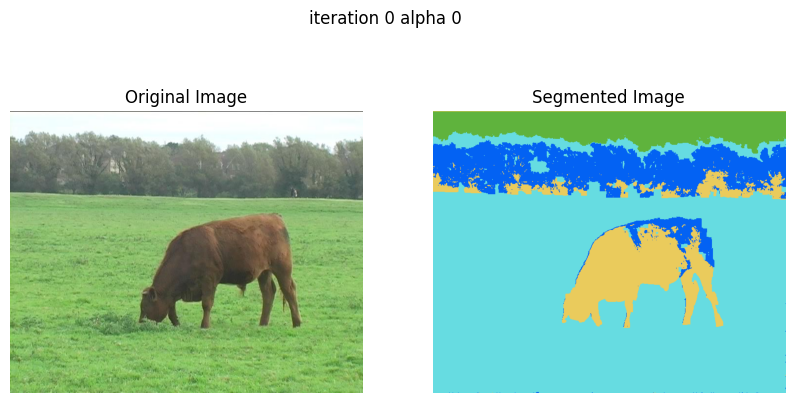

energy 12809621.851808785
computed energy 12791492.144566653 is it greater than initial energy? False


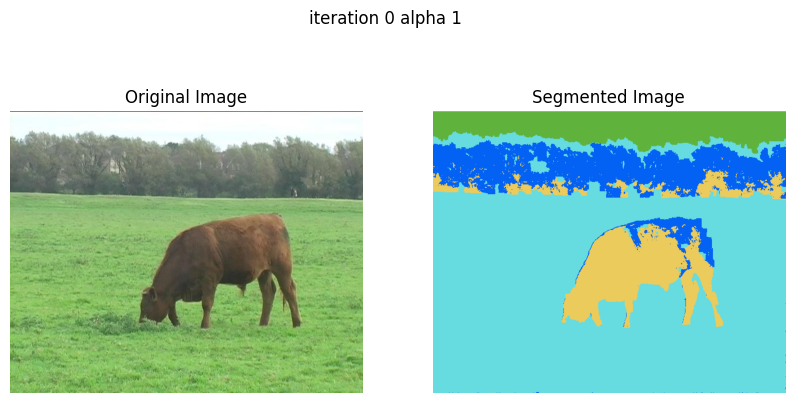

energy 12791492.144566653
computed energy 11695829.668100078 is it greater than initial energy? False


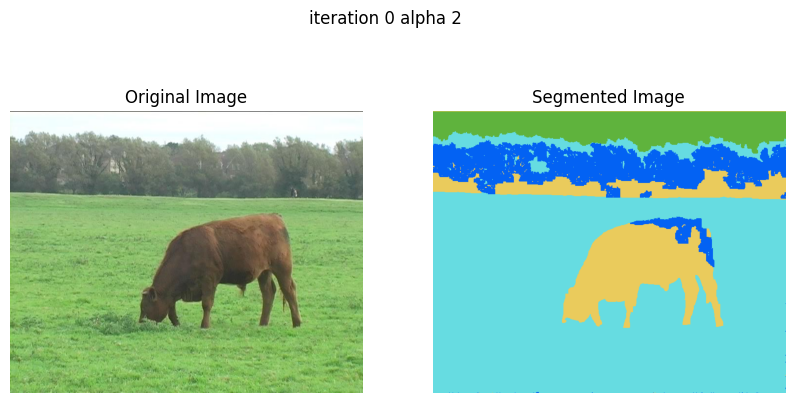

energy 11695829.668100078
computed energy 10851918.854482064 is it greater than initial energy? False


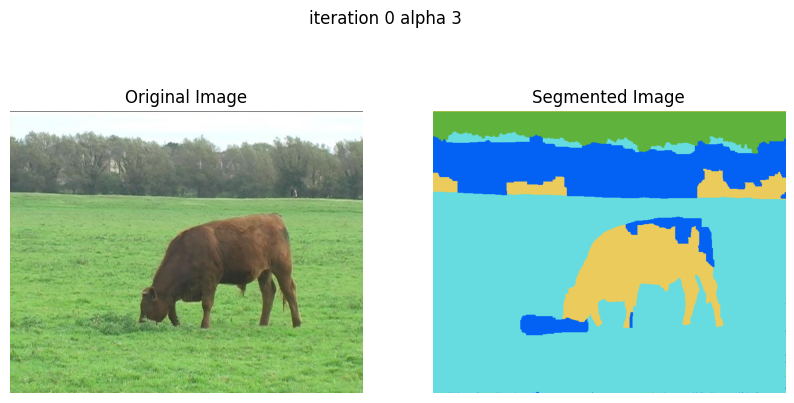

energy 10851918.854482064
iterations nb: 1
computed energy 10851891.977628741 is it greater than initial energy? False


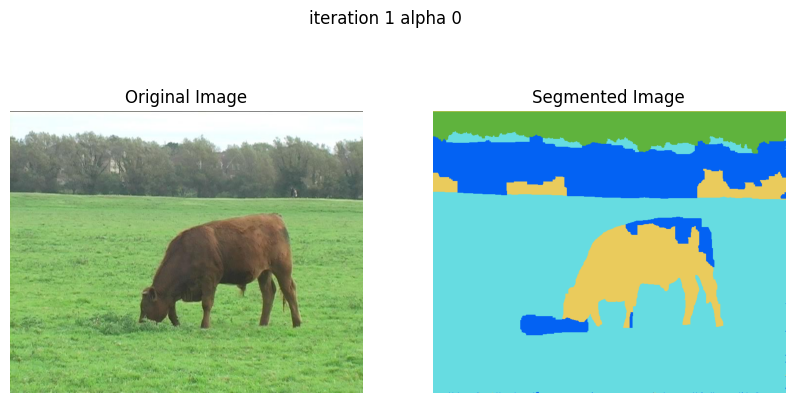

energy 10851891.977628741
computed energy 10848577.943099648 is it greater than initial energy? False


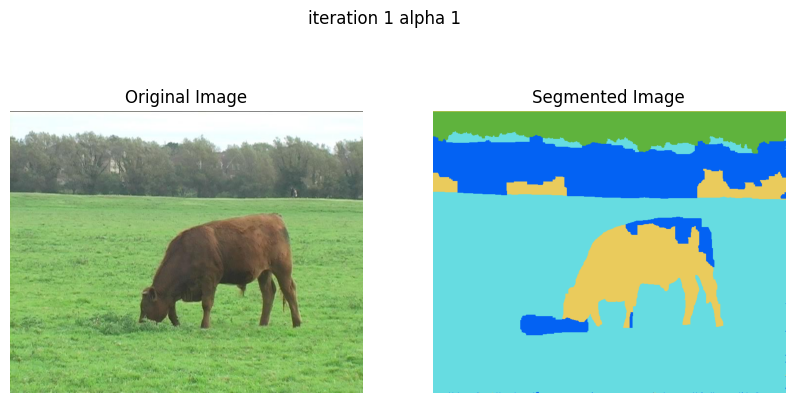

energy 10848577.943099648
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False
iterations nb: 2
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False
iterations nb: 3
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False
computed energy 10848577.943099648 is it greater than initial energy? False


In [8]:
labels=np.argmin(unary_term, axis=2)
print(labels.shape)
from graph_cut.alpha_expansion import Alpha_expansion2
a_exp=Alpha_expansion2(image=image,unary=unary_term,pairwise=pairwise_term,K=K,max_iterations=4)
labels=a_exp.run(image)

## Other iterations:


In [9]:
unary_term.shape

(576, 720, 4)

In [10]:
unary_term[0,0,:]

array([241.711544  , 420.25536511, 114.75231215, 183.86249281])

In [11]:
np.partition(unary_term[0,0,:],2)

array([114.75231215, 183.86249281, 241.711544  , 420.25536511])

In [12]:
def unary_recycle(unary, label, K):
    #! CHATGPT
    """Constructs a new unary term for the recycle algorithm."""
    unary_term = np.zeros_like(unary)
    
    for i in range(unary.shape[0]):
        for j in range(unary.shape[1]):
            partition = np.partition(unary[i, j, :], 1)  # Get two smallest values
            min_unary = partition[1] if unary[i, j, label] == partition[0] else partition[0]
            
            for k in range(K):
                unary_term[i, j, k] = unary[i, j, k] if k == label else min_unary
    return unary_term
unary_term_recycled=unary_recycle(unary_term,0,K)


In [13]:
pairwise_term.shape

(576, 720, 4, 4)

In [14]:
def binary_recycle(pairwise_term,K):
    # Construct the new binary term used for the recycle alogorithm for label lm
    pairwise_term_recycled=np.zeros((pairwise_term.shape[0],pairwise_term.shape[1],K))
    return pairwise_term

In [15]:
pairwise_term_recycled=binary_recycle(pairwise_term,K)
pairwise_term_recycled.shape

(576, 720, 4, 4)

In [16]:

class recycle_alpha_expansion:
    def __init__(self,image,unary,pairwise,K,max_iterations):
        self.l_energy=[]
        self.unary=unary
        self.pairwise=pairwise
        self.K=K
        self.h=image.shape[0]
        self.w=image.shape[1]
        self.max_iterations=max_iterations
        # labels = np.argmin(unary, axis=2)  # Initialize labels using unary term
        # labels = initialize_labels_bis(image,method=method, K=K)
        
    def construct_graph(self,alpha,labels):
        graph = maxflow.Graph[float]()
        h=self.h
        w=self.w
        nodes = graph.add_nodes(h * w)

        pairwise=self.pairwise
        unary=self.unary

        for i in range(h):
            for j in range(w):
        # Add unary terms
                pixel_index = i * w + j
                if labels[i, j] == alpha:
                    graph.add_tedge(nodes[pixel_index], unary[i, j, alpha], np.inf)  # Keep alpha pixels fixed
                else:
                    graph.add_tedge(nodes[pixel_index], unary[i, j, alpha], unary[i, j, labels[i, j]])
        
        # Add pairwise terms
                if i < h-1:
                    neighbor_index_down = pixel_index + w
                    
                    weight_down = pairwise[i, j, labels[i, j], alpha]

                    if labels[i,j] != labels[i+1,j]:
                        aux_node = graph.add_nodes(1)
                        graph.add_edge(nodes[pixel_index], aux_node, weight_down, weight_down)
                        graph.add_edge(nodes[neighbor_index_down], aux_node, pairwise[i+1,j,labels[i+1,j],alpha], pairwise[i+1,j,labels[i+1,j],alpha])
                    
                        graph.add_tedge(aux_node, 0, weight_down)

                    else:
                        graph.add_edge(nodes[pixel_index], nodes[neighbor_index_down], weight_down, weight_down)
                    
                if j < w-1:
                    neighbor_index_right = pixel_index + 1
                    weight_right = pairwise[i, j, labels[i, j], alpha]
                    if labels[i,j] != labels[i,j+1]:
                        aux_node = graph.add_nodes(1)
                        graph.add_edge(nodes[pixel_index], aux_node, weight_right, weight_right)
                        graph.add_edge(nodes[neighbor_index_right],aux_node, pairwise[i,j+1,labels[i,j+1],alpha], pairwise[i,j+1,labels[i,j+1],alpha])
                        graph.add_tedge(aux_node, 0, weight_right)
                    else:
                        graph.add_edge(nodes[pixel_index], nodes[neighbor_index_right], weight_right, weight_right)
        return graph,nodes
    

    def run(self,image,init_assignments=None):
        h, w, _ = image.shape
        unary=self.unary
        pairwise=self.pairwise
        l_energy=self.l_energy
        K=self.K
        max_iterations=self.max_iterations
        if init_assignments is not None:
            labels = init_assignments
        else:
            labels = np.argmin(unary, axis=2)
        show_segmentation(image, labels,title="initialization")
        energy=compute_energy(labels,unary,pairwise)
        l_energy.append(energy)
        assigned_labels=np.zeros((h,w)) # Will be True iif the pixel is assigned to a label and will not move
        print("first energy",compute_energy(labels,unary,pairwise))
        for alpha in range(K):
            print("the alpha",alpha)
            unary_term_recycled=unary_recycle(unary, alpha, K)
            pairwise_term_recycled=binary_recycle(pairwise,K)
            self.unary=unary_term_recycled
            self.pairwise=pairwise_term_recycled
            # Construct graph
            graph,nodes=self.construct_graph(alpha,labels)
        
            # Compute min-cut
            graph.maxflow()
            
            # Update labels
            nv_labels=self.update_labels(graph,nodes, alpha,labels,assigned_labels=assigned_labels)
            nv_energy=compute_energy(nv_labels,unary,pairwise)
            print("computed energy",nv_energy,"it is inférieur à l'énergie actuel?",nv_energy<energy)
        
            labels=nv_labels
            energy=nv_energy
            l_energy.append(energy)
                

            show_segmentation(image, labels, K,title=f"iteration {_} alpha {alpha}")
            print("energy",compute_energy(labels,unary,pairwise))
        print("FOR DEBUG")

        print("final segmentation",show_segmentation(image, labels, K))
        return labels
        # if _ % 5 == 0:
        #     show_segmentation(image, labels, K)

    def update_labels(self,graph,nodes, alpha,labels,assigned_labels):
        h,w=self.h,self.w
        nv_labels=labels.copy()
        for i in range(h):
            for j in range(w):
                pixel_index = i * w + j
                if graph.get_segment(nodes[pixel_index]) == 1: #!
                    print("updated label",i,j,alpha)
                    nv_labels[i, j] = alpha
                    if assigned_labels[i,j]==0:
                        assigned_labels[i,j]=1
                    else:
                        print("we have already assigned this pixel to a label, is it normal?",assigned_labels[i,j],i,j)
        return nv_labels
recycle=recycle_alpha_expansion(image=image,unary=unary_term_recycled,pairwise=pairwise_term_recycled,K=K,max_iterations=1)


In [47]:
recycle=recycle_alpha_expansion(image=image,unary=unary_term_recycled,pairwise=pairwise_term_recycled,K=K,max_iterations=1)


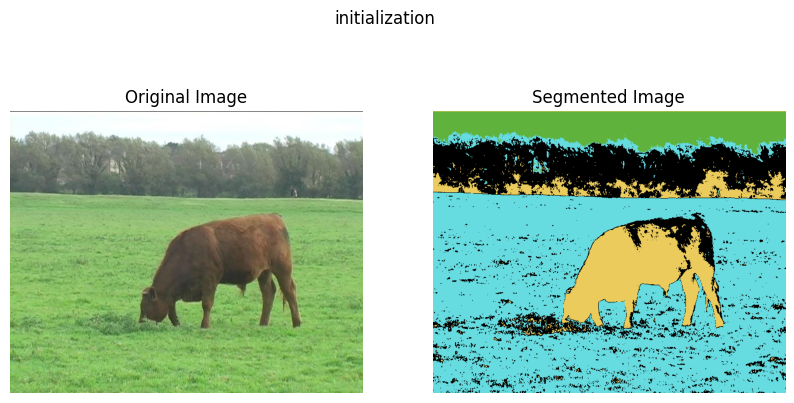

IndexError: index 2 is out of bounds for axis 2 with size 2

In [48]:
init_assigment=np.argmin(unary_term, axis=2)
recycle.run(image=image,init_assignments=init_assigment)

## Step 2 : instead with 2 class


In [ ]:
def unary_recycle(unary, label, K):
    #! CHATGPT
    """Constructs a new unary term for the recycle algorithm."""
    W,H,k=unary.shape
    unary_term = np.zeros((W,H,2))
    
    for i in range(unary.shape[0]):
        for j in range(unary.shape[1]):
            partition = np.partition(unary[i, j, :], 1)  # Get two smallest values
            min_unary = partition[1] if unary[i, j, label] == partition[0] else partition[0]
            unary_term[i,j,0]=unary[i,j,label]
            unary_term[i,j,1]=min_unary
            
            
    return unary_term
unary_term_recycled=unary_recycle(unary_term,0,K)
unary_term_recycled.shape

(576, 720, 2)

In [45]:
unary_term.shape

(576, 720, 4)

In [21]:
def binary_recycle(pairwise_term,K):
    # Construct the new binary term used for the recycle alogorithm for label lm
    pairwise_term_recycled=np.zeros((pairwise_term.shape[0],pairwise_term.shape[1],2,2))
    for i in range(pairwise_term.shape[0]):
        for j in range(pairwise_term.shape[1]):
            gamma=pairwise_term[i,j,0,1]
            pairwise_term_recycled[i,j,0,1]=pairwise_term_recycled[i,j,1,0]=gamma
           
    return pairwise_term_recycled
pairwise_term_recycled=binary_recycle(pairwise_term,K)

In [105]:

class recycle_alpha_expansion2:
    # to remove the self.assigned labels , just remove the if condition in the construct graph
    def __init__(self,image,unary,pairwise,K,max_iterations):
        self.l_energy=[]
        self.unary=unary
        self.pairwise=pairwise
        self.K=K
        self.h=image.shape[0]
        self.w=image.shape[1]
        self.max_iterations=max_iterations
        self.epsilon=-1
        self.assigned_labels=np.ones((self.h,self.w))*self.epsilon
        self.cst=0 #! Cstant term in the energy
        # labels = np.argmin(unary, axis=2)  # Initialize labels using unary term
        # labels = initialize_labels_bis(image,method=method, K=K)
        
    def construct_graph(self,alpha,labels,assigned_labels):
        graph = maxflow.Graph[float]()
        h=self.h
        w=self.w
        nodes = graph.add_nodes(h * w)

        pairwise=self.pairwise
        unary=self.unary

        for i in range(h):
            for j in range(w):
        # Add unary terms
                pixel_index = i * w + j
                if assigned_labels[i,j]==self.epsilon:
                    graph.add_tedge(nodes[pixel_index], unary[i, j,0], unary[i,j,1])  # Keep alpha pixels fixed

        
        # Add pairwise terms
                if i < h-1:
                    neighbor_index_down = pixel_index + w
                    
                    weight_down = pairwise[i, j,0,1] #?

                    if assigned_labels[i,j] ==self.epsilon and assigned_labels[i+1,j]==self.epsilon:
                        graph.add_edge(nodes[pixel_index], nodes[neighbor_index_down], weight_down, weight_down)
                    
                if j < w-1:
                    neighbor_index_right = pixel_index + 1
                    weight_right = pairwise[i, j, 0,1]
                    if assigned_labels[i,j] ==self.epsilon and assigned_labels[i,j+1]==self.epsilon:
                        graph.add_edge(nodes[pixel_index], nodes[neighbor_index_right], weight_right, weight_right)
        return graph,nodes
    

    def run(self,image,init_assignments=None):
        h, w, _ = image.shape
        unary=self.unary.copy()
        print("unary",unary.shape)
        pairwise=self.pairwise
        l_energy=self.l_energy
        K=self.K
        max_iterations=self.max_iterations
        if init_assignments is not None:
            labels = init_assignments
        else:
            labels = np.argmin(unary, axis=2)
        # project to int 
        labels=labels.astype(np.int32)
        show_segmentation(image, labels,title="initialization")
        # energy=compute_energy(labels,unary,pairwise)
        l_energy.append(energy)
        assigned_labels=self.assigned_labels # Will be True iif the pixel is assigned to a label and will not move
        # print("first energy",compute_energy(labels,unary,pairwise))
        for alpha in range(K):
            print("the alpha",alpha)
            print("unary",unary.shape)
            print("assinged labels",np.unique(assigned_labels))
            unary_term_recycled=unary_recycle(unary, alpha, K)
            pairwise_term_recycled=binary_recycle(pairwise,K)
            self.unary=unary_term_recycled
            self.pairwise=pairwise_term_recycled
            # Construct graph
            graph,nodes=self.construct_graph(alpha,labels,assigned_labels=assigned_labels)
            print(len(nodes))
            # Compute min-cut
            graph.maxflow()
            
            print(" IS MAXFLOW WORKING?")
            # Update labels
            nv_labels,assigned_labels=self.update_labels(graph,nodes, alpha,labels,assigned_labels=assigned_labels)
            # nv_energy=compute_energy(nv_labels,unary,pairwise)
            # print("computed energy",nv_energy,"it is inférieur à l'énergie actuel?",nv_energy<energy)
            unary,pairwise=self.project(nv_labels,assigned_labels,unary,pairwise)
            labels=nv_labels
            # energy=nv_energy
            l_energy.append(energy)
                

            show_segmentation(image, labels, K,title=f"iteration {_} alpha {alpha}")
            # return labels,assigned_labels

        print("final segmentation",show_segmentation(image, labels, K))
        return labels,assigned_labels,self.cst
        # if _ % 5 == 0:
        #     show_segmentation(image, labels, K)

    def project(self,labels,assigned_labels,unary,pairwise):
        # Project the function Using the initial code. 
        # Slide the pairwise term and update the corresponding pairwise term
        for i in range(self.h-1):
            for j in range(self.w-1):
                idx1=[]
                idx2=[]
                if i < self.h-1:
                    idx1.append((i,j))
                    idx2.append((i+1,j))
                if j < self.w-1:
                    idx1.append((i,j))
                    idx2.append((i,j+1))
                for l in range(len(idx1)):
                    node=idx1[l]
                    neighbor=idx2[l]
                    # print("node",node,"neighbor",neighbor)

                    if assigned_labels[node]==self.epsilon and assigned_labels[neighbor]!=self.epsilon:
                        for k in range(self.K):

                            unary[node[0],node[1],k]+=pairwise_term[node[0],node[1],k,labels[neighbor[0],neighbor[1]]]
                    elif assigned_labels[node[0],node[1]]!=self.epsilon and assigned_labels[neighbor[0],neighbor[1]]==self.epsilon:
                        for k in range(self.K):
                            unary[neighbor[0],neighbor[1],k]+=pairwise_term[node[0],node[1],labels[node[0],node[1]],k]
                    elif assigned_labels[node[0],node[1]]!=self.epsilon and assigned_labels[neighbor[0],neighbor[1]]!=self.epsilon:
                        self.cst+=pairwise_term[node[0],node[1],labels[node[0],node[1]],labels[neighbor[0],neighbor[1]]]
                
        # Update the pairwise term
        for i in range(self.h):
            for j in range(self.w):
                if assigned_labels[i,j]!=self.epsilon:
                    self.cst+=unary_term[i,j,labels[i,j]]
        return unary,pairwise
                
                        
    def update_labels(self,graph,nodes, alpha,labels,assigned_labels):
        h,w=self.h,self.w
        nv_labels=labels.copy()
        for i in range(h):
            for j in range(w):
                pixel_index = i * w + j
                if graph.get_segment(nodes[pixel_index]) == 1: #!
                    # print("updated label",i,j,alpha)
                    nv_labels[i, j] = alpha
                    if assigned_labels[i,j]==self.epsilon:
                        assigned_labels[i,j]=1
                    else:
                        print("we have already assigned this pixel to a label, is it normal?",assigned_labels[i,j],i,j)
        return nv_labels,assigned_labels
recycle=recycle_alpha_expansion2(image=image,unary=unary_term,pairwise=pairwise_term,K=K,max_iterations=1)


unary (576, 720, 4)


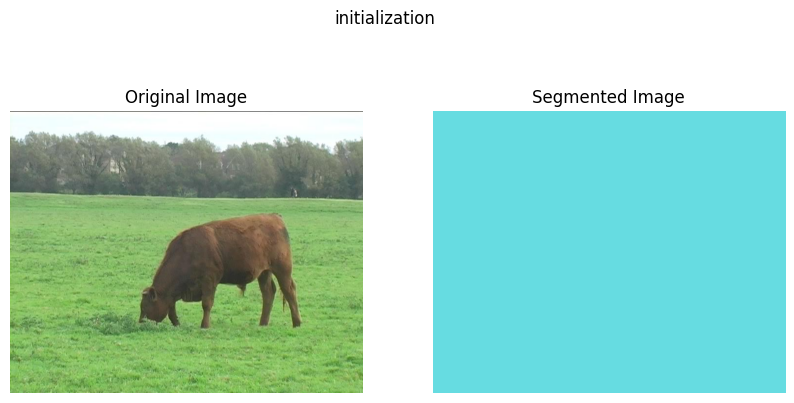

the alpha 0
unary (576, 720, 4)
assinged labels [-1.]
414720
 IS MAXFLOW WORKING?


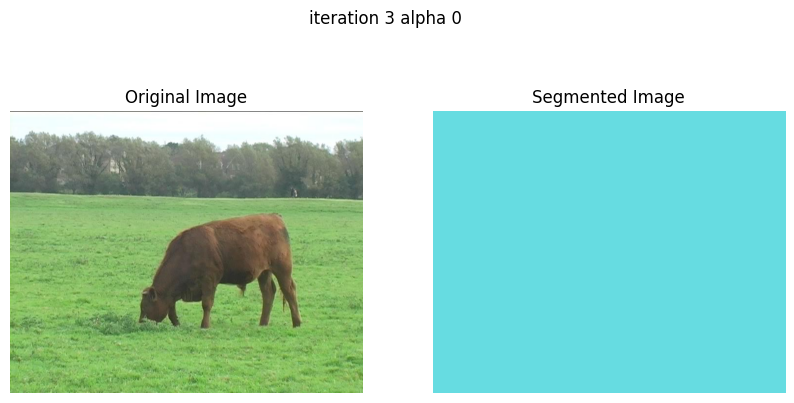

the alpha 1
unary (576, 720, 4)
assinged labels [-1.  1.]
414720
 IS MAXFLOW WORKING?


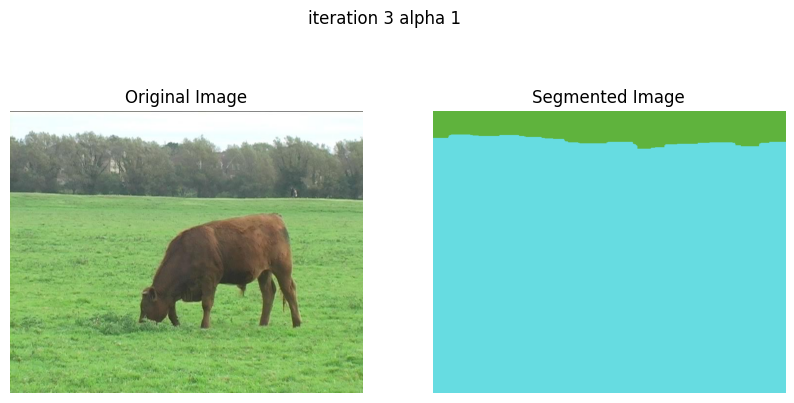

the alpha 2
unary (576, 720, 4)
assinged labels [-1.  1.]
414720
 IS MAXFLOW WORKING?


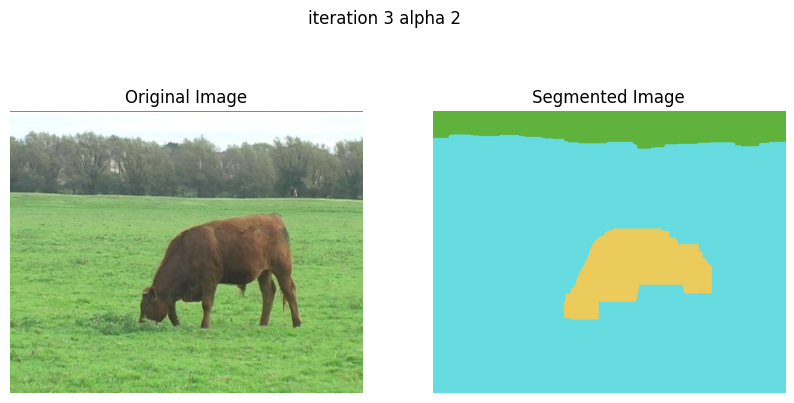

the alpha 3
unary (576, 720, 4)
assinged labels [-1.  1.]
414720
 IS MAXFLOW WORKING?


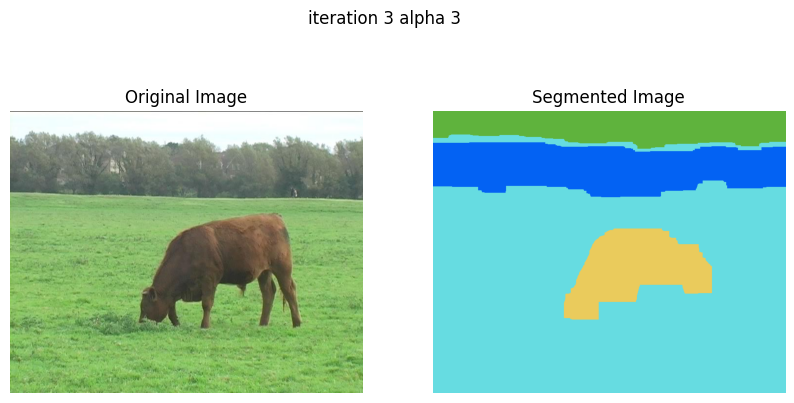

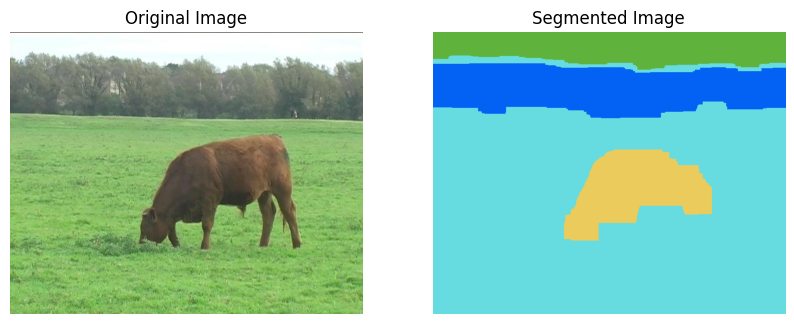

final segmentation None


In [106]:
recycle=recycle_alpha_expansion2(image=image,unary=unary_term,pairwise=pairwise_term,K=K,max_iterations=1)

init_assigment=np.zeros((image.shape[0],image.shape[1]))*-1 #! No assignement
nv_labels,assigned_labels,cst=recycle.run(image=image,init_assignments=init_assigment)


array([-1.,  1.])

In [73]:
np.unique(nv_labels)

array([0., 1., 2., 3.])

In [80]:
np.unique(assigned_labels)

array([1.])

In [77]:
nv_labels

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(576, 720))